# Apply Photometric Classification To Fit Results

This notebook applies the photometric classification method from González-Gaitán et al. 2014 to SDSS, DES, and CSP light-curve fits. Results are then used to analyze the properties of peculiar supernovae.

In [2]:
import sys

import numpy as np
import pandas as pd
import sncosmo
from astropy.table import Table
from bokeh.io import output_notebook
from bokeh.palettes import Category20
from bokeh.plotting import figure
from matplotlib import pyplot as plt
from scipy import optimize
from sklearn.utils import resample

sys.path.insert(0, '../')
from analysis_pipeline.data_access import csp
from analysis_pipeline import SN91bgSource
from read_data import get_fit_results


## Load Data

We begin by reading in SNCosmo fit results for SDSS, DES, and CSP. This includes fits that use all observed bands, along with those that exclusively use the restframe blue and restframe red filters.

In [3]:
data_dir = '../pipeline_outputs'
salt_2_4 = sncosmo.Model(source=sncosmo.get_source('salt2', version='2.4'))
sn_91bg = sncosmo.Model(source=SN91bgSource())

for survey in ('csp', 'des'):
    for model in (salt_2_4, sn_91bg):
        for param_num in (4,):
            var_pattern = f'{survey}_{model.source.name}_{param_num}p_{{}}'
            all_bands, blue, red = get_fit_results(survey, model, param_num, data_dir)
            
            globals()[var_pattern.format('all')] = all_bands
            globals()[var_pattern.format('blue')] = blue
            globals()[var_pattern.format('red')] = red

csp_sn91bg_4p_all.head()


,num_points_91bg_proj_csp_u,num_points_91bg_proj_csp_g,num_points_91bg_proj_csp_r,num_points_91bg_proj_csp_i,num_points_91bg_proj_csp_B,num_points_91bg_proj_csp_V0,num_points_91bg_proj_csp_V1,num_points_91bg_proj_csp_V,num_points_91bg_proj_csp_Y,num_points_91bg_proj_csp_H,...,x1,c,z_err,t0_err,x0_err,x1_err,c_err,chi,dof,message
cid,,,,,,,,,,,,,,,,,,,,,
2008J,8.0,10.0,10.0,9.0,10.0,0.0,0.0,10.0,10.0,3.0,...,1.250000,1.000000e+00,0.0,0.025632,8.435891e-17,0.000016,0.000011,64116.526035,53.0,Minimization exited successfully.
2005kc,9.0,13.0,12.0,13.0,13.0,13.0,0.0,0.0,18.0,16.0,...,1.250000,5.329071e-15,0.0,0.012252,2.667057e-17,0.000014,0.000020,27317.341276,69.0,Minimization exited successfully.
2005A,0.0,28.0,33.0,33.0,17.0,28.0,0.0,0.0,0.0,15.0,...,1.250000,5.994204e-01,0.0,0.091139,1.049786e-16,0.000003,0.010790,43734.905317,149.0,Covariance may not be accurate. Covariance not...
2009Y,29.0,27.0,28.0,31.0,30.0,0.0,0.0,30.0,29.0,26.0,...,1.250000,6.913758e-11,0.0,0.009965,5.706920e-17,0.000003,0.000002,253998.724483,177.0,Minimization exited successfully.
2004gs,19.0,49.0,50.0,46.0,43.0,53.0,0.0,0.0,0.0,7.0,...,1.104365,9.179824e-12,0.0,0.034963,5.584128e-17,0.010469,0.000004,42945.846122,273.0,Covariance may not be accurate. Covariance not...


Next, we calculate the difference in normalized chi-squared values between the Ia and 91bg models. In algebraic form, this is to say we calculate the following:

$$\chi^2_{blue, \, red}(Ia) - \chi^2_{blue, \, red}(91bg)$$


In [4]:
def calc_chisquared_diff(snia_blue, snia_red, bg_blue, bg_red):
    """Calculate the difference between the normalized chi-squared
    of the Salt and 91bg model in restframe blue and red bands

    Args:
        snia_blue (DataFrame): Salt fit results in the resftram blue
        snia_red  (DataFrame): Salt fit results in the resftram red
        bg_blue   (DataFrame): 91bg fit results in the resftram blue
        bg_red    (DataFrame): 91bg fit results in the resftram red
        
    Returns:
        A DataFrame with columns 'red' and 'blue'
    """
    
    combined_snia = snia_blue.join(snia_red, lsuffix='_blue', rsuffix='_red')
    combined_snia['chi_norm_blue'] = combined_snia['chi_blue'] / combined_snia['dof_blue']
    combined_snia['chi_norm_red'] = combined_snia['chi_red'] / combined_snia['dof_red']
    
    combined_91bg = bg_blue.join(bg_red, lsuffix='_blue', rsuffix='_red')
    combined_91bg['chi_norm_blue'] = combined_91bg['chi_blue'] / combined_91bg['dof_blue']
    combined_91bg['chi_norm_red'] = combined_91bg['chi_red'] / combined_91bg['dof_red']
    
    # Calculate chi-squared differences
    chi_squared_values = pd.DataFrame({
        'blue': combined_snia['chi_norm_blue'] - combined_91bg['chi_norm_blue'],
        'red': combined_snia['chi_norm_red'] - combined_91bg['chi_norm_red']
    })
    
    return chi_squared_values.dropna()


csp_chi_diff = calc_chisquared_diff(csp_salt2_4p_blue, csp_salt2_4p_red, csp_sn91bg_4p_blue, csp_sn91bg_4p_blue)

csp_chi_diff.head()


,blue,red
cid,,
2008J,-366.050570,-367.958316
2005kc,-170.544434,-173.284918
2005A,-42.983351,-45.717328
2009Y,3464.075689,4518.779471
2004gs,349.528089,604.131350


Lets plot the above DataFrame. Note that we draw dashed lines intersecting at (0, 0) for visual reference only.

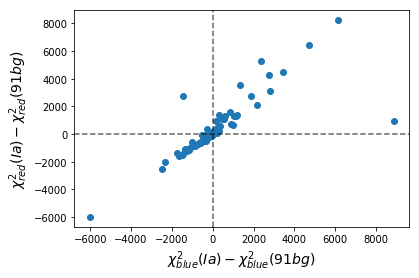

In [5]:
plt.scatter(csp_chi_diff['blue'], csp_chi_diff['red'], label='CSP')

plt.axhline(0, linestyle='--', color='black', alpha=.6)
plt.axvline(0, linestyle='--', color='black', alpha=.6)
plt.xlabel(r'$\chi^2_{blue}(Ia) - \chi^2_{blue}(91bg)$', fontsize=14)
plt.ylabel(r'$\chi^2_{red}(Ia) - \chi^2_{red}(91bg)$', fontsize=14)

plt.show()


# Optimize FOM

We use a figure of merit (FOM) value as an optimization parameter for training our classification. The FOM is defined as:

$$FOM = \frac{N_{true}}{N_{tot}} * \frac{N_{true}}{N_{true} + N_{false}}$$

where $N_{true}$ is the number of correctly identified objects of a given type (e.g. 91bg-like objects), $N_{tot}$ is the total input number of that type and $N_{false}$ is the number of objects. In order to calculate this parameter, we will need to construct a DataFrame containing the known classifications of spectroscopically observed targets along with the chi-squared differences from above.


In [6]:
csp_spec_class = csp.master_table['SN', 'SNID']
csp_spec_class.rename_column('SNID', 'type')
csp_spec_class.rename_column('SN', 'cid')
csp_spec_class = csp_spec_class[~csp_spec_class['type'].mask]

classification_data = csp_spec_class.to_pandas()
classification_data = classification_data.set_index('cid')
classification_data = csp_chi_diff.join(classification_data)
classification_data.fillna('Unknown', inplace=True)

classification_data.head()


,blue,red,type
cid,,,
2008J,-366.050570,-367.958316,Unknown
2005kc,-170.544434,-173.284918,Normal
2005A,-42.983351,-45.717328,Normal
2009Y,3464.075689,4518.779471,Normal
2004gs,349.528089,604.131350,Normal


Next, we write a few functions to determine the optimal chi-squared boundaries based on the FOM. We include functions for two types of classification boundaries. The first calculates the FOM using a verticle and horizontal boundary. The second uses a single boundary at an angle. 

In [7]:
def calc_rect_fom(dataframe, blue_cutoff, red_cutoff):
    """Calculate the rectangular figure of merrit for a set of classifications
    
    args:
        dataframe   (float): 
        blue_cutoff (float): 
        red_cutoff  (float): 
        
    Returns:
        The figure of merit value
    """

    is_91bg_true = dataframe['type'] == '91bg'
    is_91bg_classified = (
            (dataframe['blue'] > blue_cutoff)
            & (dataframe['red'] > red_cutoff)
    )

    num_tot = sum(is_91bg_true)  # How to handle multiple types?
    num_true = sum(is_91bg_true == is_91bg_classified)
    num_false = len(dataframe) - num_true
    return (num_true / num_tot) * (num_true / (num_true + num_false))


def calc_diagonal_fom(dataframe, m, b):
    """Calculate the rectangular figure of merrit for a set of classifications
    
    args:
        dataframe   (float): 
        blue_cutoff (float): 
        red_cutoff  (float): 
        
    Returns:
        The figure of merit value
    """

    is_91bg_true = dataframe['type'] == '91bg'
    is_91bg_predict = m * dataframe['blue'] + b
    is_91bg_classified = dataframe['red'] >= is_91bg_predict

    num_tot = sum(is_91bg_true)  # How to handle multiple types?
    num_true = sum(is_91bg_true == is_91bg_classified)
    num_false = len(dataframe) - num_true
    return (num_true / num_tot) * (num_true / (num_true + num_false))


In [8]:
print('Rectangular FOM:')
initial_fom = calc_rect_fom(classification_data, 0, 0)
print(f'FOM at (0, 0): {initial_fom}\n')

inverse_fom = lambda args: 1 / calc_rect_fom(classification_data, *args)
rect_result = optimize.minimize(inverse_fom, [0, 0])
rect_result['fun'] = 1 / rect_result['fun']
print('Optimization results:')
print(rect_result)

print('\n\nAngled FOM:')
initial_fom = calc_diagonal_fom(classification_data, -1, 0)
print(f'FOM at (-1, 0): {initial_fom}\n')

inverse_fom = lambda args: 1 / calc_diagonal_fom(classification_data, *args)
angl_result = optimize.minimize(inverse_fom, [-1, 0])
angl_result['fun'] = 1 / angl_result['fun']
print('Optimization results:')
print(angl_result)

print('\n\nAngled FOM at 45 degrees:')
initial_fom = calc_diagonal_fom(classification_data, -1, 0)
print(f'FOM at (-1, 0): {initial_fom}\n')

inverse_fom = lambda b: 1 / calc_diagonal_fom(classification_data, -1, b)
angl_45_result = optimize.minimize(inverse_fom, 0)
angl_45_result['fun'] = 1 / angl_45_result['fun']
print('Optimization results:')
print(angl_45_result)


Rectangular FOM:
FOM at (0, 0): 6.22692036645525

Optimization results:
      fun: 6.22692036645525
 hess_inv: array([[1, 0],
       [0, 1]])
      jac: array([0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 4
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([0., 0.])


Angled FOM:
FOM at (-1, 0): 5.212121212121212

Optimization results:
      fun: 5.212121212121212
 hess_inv: array([[1, 0],
       [0, 1]])
      jac: array([0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 4
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([-1.,  0.])


Angled FOM at 45 degrees:
FOM at (-1, 0): 5.212121212121212

Optimization results:
      fun: 5.212121212121212
 hess_inv: array([[1]])
      jac: array([0.])
  message: 'Optimization terminated successfully.'
     nfev: 3
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([0.])


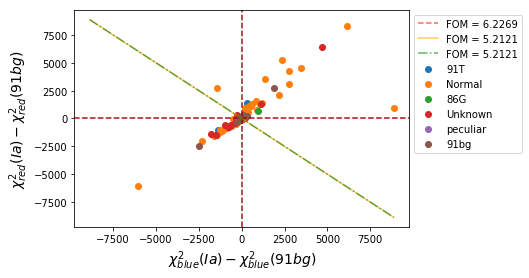

In [9]:
a = max(np.abs(classification_data['blue']))
line_points = np.array([-a, a])

for sn_type in set(classification_data['type']):
    i = classification_data['type'] == sn_type
    plt.scatter(classification_data['blue'].loc[i], 
                classification_data['red'].loc[i], 
                label=sn_type)

plt.axvline(0, linestyle='--', color='black', alpha=.6)
plt.axhline(0, linestyle='--', color='black', alpha=.6)

# Rectangular FOM
plt.axvline(rect_result.x[0], linestyle='--', color='red', alpha=.6)
plt.axhline(rect_result.x[1], linestyle='--', color='red', alpha=.6,
            label=f'FOM = {rect_result.fun:.4f}')

# Angled FOM
angl_line = angl_result.x[0] * line_points + angl_result.x[1]
plt.plot(line_points, angl_line, linestyle='-', color='orange', alpha=.6,
        label=f'FOM = {angl_result.fun:.4f}')

# Angled FOM at 45 degrees
angl_45_line = -line_points + angl_result.x[0]
plt.plot(line_points, angl_45_line, linestyle='-.', color='green', alpha=.6,
         label=f'FOM = {angl_45_result.fun:.4f}')

plt.xlabel(r'$\chi^2_{blue}(Ia) - \chi^2_{blue}(91bg)$', fontsize=14)
plt.ylabel(r'$\chi^2_{red}(Ia) - \chi^2_{red}(91bg)$', fontsize=14)

plt.legend(bbox_to_anchor=(1, 1))
plt.show()


## Bootstrap

Now that we have a figure of merit optimization, we can bootstrap our data to determine our final classification parameters.

In [17]:
# configure bootstrap
n_iterations = 1000
n_size = int(len(classification_data) * 0.50)

# run bootstrap
fom_values = []
classification_params = []
for i in range(n_iterations):
    # prepare train and test sets
    sample_data = resample(classification_data, n_samples=n_size)
    inverse_fom = lambda args: 1 / calc_rect_fom(classification_data, *args)
    result = optimize.minimize(inverse_fom, [0, 0])

    fom_values.append(1 / result.fun)
    classification_params.append(result.x)

classification_params = np.array(classification_params).T

In [23]:
def calc_confidence_intervals(alpha, stats):
    p = ((1 - alpha) / 2) * 100
    lower = max(0, np.percentile(stats, p))

    p = (alpha + ((1 - alpha) / 2)) * 100
    upper = min(1.0, np.percentile(stats, p))

    return lower, upper


alpha=0.95
confidence = 0.95
average_fom = np.average(fom_values)
fom_interval = calc_confidence_intervals(confidence, fom_values)

print(f'Average FOM: {average_fom}')
print(f'{alpha * 100:.1f} confidence interval: [{fom_interval[0] * 100:.1f} '
      f', {fom_interval[1] * 100:.1f}]')

average_params = np.average(classification_params, axis=1)
blue_param_interval = calc_confidence_intervals(confidence, classification_params[0])
red_param_interval = np.average(classification_params[1])

print(f'Average classification params: {average_params}')
print(f'{alpha * 100:.1f} confidence interval for blue '
      f'param: [{blue_param_interval[0] * 100:.1f} '
      f', {blue_param_interval[1] * 100:.1f}]')

print(f'{alpha * 100:.1f} confidence interval for red '
      f'param: [{red_param_interval[0] * 100:.1f} '
      f', {red_param_interval[1] * 100:.1f}]')


Average FOM: 6.226920366455248
95.0 confidence interval: [622.7 , 100.0]
Average classification params: [0. 0.]


IndexError: invalid index to scalar variable.

In [ ]:
plt.scatter(sdss_chi_diff['blue'], sdss_chi_diff['red'], label='SDSS')
plt.scatter(des_chi_diff['blue'], des_chi_diff['red'], label='DES')
plt.scatter(csp_chi_diff['blue'], csp_chi_diff['red'], label='CSP')

plt.axvline(0, linestyle='--', color='black', alpha=.6)
plt.axhline(0, linestyle='--', color='black', alpha=.6)
plt.axvline(average_params[0], linestyle='--', color='red', alpha=.6)
plt.axhline(average_params[1], linestyle='--', color='red', alpha=.6,
            label=f'FOM = {1 / result.fun}')

plt.xlabel(r'$\chi^2_{blue}(Ia) - \chi^2_{blue}(91bg)$', fontsize=14)
plt.ylabel(r'$\chi^2_{red}(Ia) - \chi^2_{red}(91bg)$', fontsize=14)

plt.legend()
plt.show()
